<a href="https://colab.research.google.com/github/sibarras/PythonExamples/blob/master/asignaci%C3%B3n_4_Algoritmo_Genetico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algoritmo Genético - Asignación 4
# Estudiante: Samuel Ibarra

## Descripción
Realizaremos un Algoritmo para encontrar la mejor forma para la cual se podrían interconectar distintas subestaciones para disminuir los kilometros de líneas para interconectar los distintos puntos de consumo.

Primeramente definimos las librerías a utilizar para el programa.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

## Objetos del Programa
Crearemos las clases para los objetos que utilizaremos para que el algoritmo genético los utilize tanto como inputs como outputs, estos objetos son pieza clave para nuestro algoritmo genético.

In [2]:
class Generadora:
  def __init__(self, generacion:int, x:int, y:int):
    self.generacion = generacion
    self.x = x
    self.y = y

  def __repr__(self):
    return 'Generadora(Producción:{}, pos[{},{}])'.format(self.generacion, self.x, self.y)


class Subestacion:
  def __init__(self, carga:int, x=int, y=int):
    self.carga = carga
    self.x = x
    self.y = y
    self.withgen = False

  def __repr__(self):
    return 'Subestación(Carga:{}, pos[{},{}])'.format(self.carga, self.x, self.y)


class Usuario:
  def __init__(self, demanda:int, x:int, y:int):
    self.demanda = demanda
    self.x = x
    self.y = y

  def __repr__(self):
    return 'Usuario(Demanda:{}, pos[{},{}])'.format(self.demanda, self.x, self.y)


class Conexion:
  def __init__(self, inicio, fin):
    self.inicio = inicio
    self.fin = fin
  
  @property
  def distancia(self):
    distancia_x = self.fin.x - self.inicio.x
    distancia_y = self.fin.y - self.inicio.y
    return ( distancia_x**2 + distancia_y**2 )**0.5

  def __repr__(self):
    return 'Conexion(Distancia:{})'.format(self.distancia)

  @property
  def costo(self):
    if type(self.inicio) is Generadora and type(self.fin) is Subestacion:
      return COSTO_LINEA_GENERADORA*self.distancia
    elif type(self.inicio) is Subestacion and type(self.fin) is Usuario:
      return COSTO_LINEA_DISTRIBUIDORA*self.distancia
    print(str(self.inicio), str(self.fin))
    return None


## Algoritmo Genético
Ahora, utilizaremos estas estructuras de datos, para alimentar nuestro algoritmo y que pueda retornar las conexiones óptimas para esta distribución de subestaciones. Para esto, primero definiremos como sería un único caso o individuo en una generación determinada.

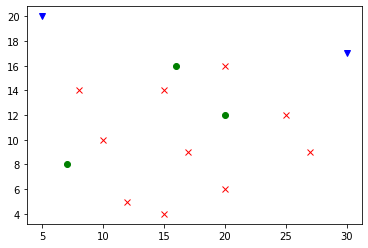

In [3]:
# Generadoras (Estáticas en el algoritmo)
bayano = Generadora(200, 30, 17)
fortuna = Generadora(150, 5, 20)
lista_de_generadoras = [bayano, fortuna]

# Usuarios (Estáticos en el algoritmo)
machetazo = Usuario(10, 10, 10)
xtra =      Usuario(10, 12, 5)
cemex =     Usuario(60, 25, 12)
casa1 =     Usuario(2, 15, 4)
casa2 =     Usuario(4, 20, 6)
casa3 =     Usuario(2, 15, 14)
casa4 =     Usuario(4, 20, 16)
casa5 =     Usuario(2, 8, 14)
casa6 =     Usuario(4, 17, 9)
hotel =     Usuario(8, 27, 9)
lista_de_usuarios = [machetazo, xtra, cemex, casa1, casa2, casa3, casa4, casa5, casa6, hotel]

# Subestaciones (Variables en lugar y carga, no en cantidad)
se1 = Subestacion(8, 20, 12)
se2 = Subestacion(60, 7, 8)
se3 = Subestacion(30, 16, 16)
lista_de_subestaciones = [se1, se2, se3]

# Generadoras en Azul
gx = [generadora.x for generadora in lista_de_generadoras]
gy = [generadora.y for generadora in lista_de_generadoras]
plt.plot(gx, gy, 'bv')

# Subestaciones en Verde
sx = [subestacion.x for subestacion in lista_de_subestaciones]
sy = [subestacion.y for subestacion in lista_de_subestaciones]
plt.plot(sx, sy, 'go')

# Usuarios en Rojo
ux = [usuario.x for usuario in lista_de_usuarios]
uy = [usuario.y for usuario in lista_de_usuarios]
plt.plot(ux, uy, 'rx')
plt.show()

## Constantes del Algoritmo
Los valores que definiremos serán los que no cambiarán durante la ejecución del programa. Estos valores serán para definir las dimensiones del cromosoma.

In [4]:
# Numeros para definir el cromosoma a crear
N_USUARIOS = len(lista_de_usuarios)
N_GENERADORAS = len(lista_de_generadoras)
N_SUBESTACIONES = len(lista_de_subestaciones)
N_CROMOSOMAS = (N_GENERADORAS + N_USUARIOS) * N_SUBESTACIONES


print('Usuarios:{}, Generadoras:{}, Subestaciones:{};'.format(N_USUARIOS, N_GENERADORAS, N_SUBESTACIONES))

# Costes de las líneas
COSTO_LINEA_GENERADORA = 10
COSTO_LINEA_DISTRIBUIDORA = 1

Usuarios:10, Generadoras:2, Subestaciones:3;


## Individuo
El individuo representa una solución al problema propuesto, en este caso, la localización de las subestaciones. Para esta solución, representaremos una matriz de unos y ceros, representando las conexiones entre Generadoras, Subestaciones y Usuarios. Esta Matriz es la que evolucionará en cada generación y variará en cada generación.

Nuesto individuo generara conexiones siguiendo estas simples reglas:
1. Las generadoras solo pueden tener una conexión
2. Los usuarios solo pueden tener una subestación
3. Las subestaciones pueden interconectarse entre sí, solamente si no hay generadoras disponibles.

Cada usuario se conectará aleatoriamente a una subestación y cada generadora decidirá aleatoriamente cual subestación recibirá su energía.

Si quedan subestaciones sin energizar, se conectará esta aleatoriamente con alguna de las que están en la lista de subestaciones, excluyendose a ella misma.

El individuo representará dichas conexiones como un cromosoma con unos y ceros, en donde su longitud será de (n_g + n_u) x n_s, en donde:
n_s = número de subestaciones
n_g = número de generadoras
n_u = número de usuarios

Por lo tanto, para un caso de dos generadoras, tres subestaciones y 4 casas:


---

                  Generadora1      Generadora2
    Subestaciones   s1 s2 s3        s1 s2 s3

---
                    Usuario1   Usuario2   Usuario3   Usuario4
    Subestaciones   s1 s2 s3   s1 s2 s3   s1 s2 s3   s1 s2 s3


Cromosoma de ejemplo:

    Generadoras    Usuarios
    [001,100]   +  [001,100,001,001]


En el cromosoma se puede observar que:

* Generadora 1 se conecta con subestación 3
* Generadora 2 se conecta con subestación 1

* Casa 1 recibe de subestación 3
* Casa 2 recibe de subestación 1
* Casa 3 recibe de subestación 3
* Casa 4 recibe de subestación 3

En caso de que las casas se conecten a subestaciones sin energía, el fitness deberá ser cero, para no ser considerado en siguientes generaciones.

Crearemos una clase para representar estos objetos.

In [5]:
# Individuo como solución
class Cromosoma:
  def __init__(self):
    self.subestaciones = lista_de_subestaciones[:]
    self.generar_cadena()
  
  def __str__(self):
    return str(self.cadena)
  
  def generar_cadena(self):
    # Genera una cadena nueva de conexiones en un cromosoma
    self.cadena = np.zeros(N_CROMOSOMAS)
    self.conexion_aleatoria_generadoras()
    self.conexion_aleatoria_usuarios()
    
  def conexion_aleatoria_generadoras(self):
    # Crea conexiones entre generadoras y subestaciones y actualiza la cadena
    cadena = np.zeros(N_CROMOSOMAS)
    self.gen_cadena = cadena[:N_GENERADORAS*N_SUBESTACIONES].reshape(N_GENERADORAS, N_SUBESTACIONES)
    for gen in range(N_GENERADORAS):
      sub = np.random.randint(N_SUBESTACIONES)
      self.gen_cadena[gen][sub] = 1
      self.cadena[gen*N_SUBESTACIONES:(gen+1)*N_SUBESTACIONES]=self.gen_cadena[gen]

  def conexion_aleatoria_usuarios(self):
    cadena = np.zeros(N_CROMOSOMAS)
    self.usr_cadena = cadena[N_GENERADORAS*N_SUBESTACIONES:].reshape(N_USUARIOS, N_SUBESTACIONES)
    for usr in range(N_USUARIOS):
      sub = np.random.randint(N_SUBESTACIONES)
      self.usr_cadena[usr][sub] = 1
      self.cadena[N_GENERADORAS*N_SUBESTACIONES:][usr*N_SUBESTACIONES:(usr+1)*N_SUBESTACIONES]=self.usr_cadena[usr]

  
  def mutar_cadena(self):
    # Utiliza un cromosoma ya creado para modificarle solo un número
    
    # Primero elegimos si modificar generadora o usuario
    tipo = np.random.randint(2)
    if tipo == 0:
      # Modificamos generadora
      # Elegimos cual generadora
      gen = np.random.randint(N_GENERADORAS)
      # Elegimos a cual subestación se conectará
      sub = np.random.randint(N_SUBESTACIONES)
      while sub == list(self.gen_cadena[gen]).index(1):
        sub = np.random.randint(N_SUBESTACIONES)
      self.gen_cadena[gen] = np.zeros(N_SUBESTACIONES)
      self.gen_cadena[gen][sub] = 1
      self.cadena[gen*N_SUBESTACIONES:(gen+1)*N_SUBESTACIONES]=self.gen_cadena[gen][:]
  
    elif tipo == 1:
      # Modificamos usuario
      # Elegimos cual usuario
      usr = np.random.randint(N_USUARIOS)
      # Elegimos a cual subestación se conectará
      sub = np.random.randint(N_SUBESTACIONES)
      while sub == list(self.usr_cadena[usr]).index(1):
        sub = np.random.randint(N_SUBESTACIONES)
      self.usr_cadena[usr] = np.zeros(N_SUBESTACIONES)
      self.usr_cadena[usr][sub] = 1
      self.cadena[N_GENERADORAS*N_SUBESTACIONES:][usr*N_SUBESTACIONES:(usr+1)*N_SUBESTACIONES]=self.usr_cadena[usr][:]
  
  def combinar_cadena(self, cromosoma2):
    # Combina dos cromosomas de dos distribuciones distintas para generar
    # una nueva y guardarla en el cromosoma que llama este metodo
    for gen in range(N_GENERADORAS):
      # Intercambio conexiones de generadoras si el numero random es 1
      if np.random.randint(2) == 1:
        self.gen_cadena[gen] = cromosoma2.gen_cadena[gen]
        self.cadena[gen*N_SUBESTACIONES:(gen+1)*N_SUBESTACIONES]=self.gen_cadena[gen][:]

    for usr in range(N_USUARIOS):
      if np.random.randint(2) == 1:
        self.usr_cadena[usr] = cromosoma2.usr_cadena[usr]
        self.cadena[N_GENERADORAS*N_SUBESTACIONES:][usr*N_SUBESTACIONES:(usr+1)*N_SUBESTACIONES]=self.usr_cadena[usr][:]

  def generar_conexiones(self):
    conexiones = []
    # Para cada conexión en la cadena de generación
    for gen in range(N_GENERADORAS):
      # La subestacion es donde se encuentra el 1 en la lista de conexiones de la generadora
      self.subestaciones[list(self.gen_cadena[gen]).index(1)].withgen = True
      subestacion = self.subestaciones[list(self.gen_cadena[gen]).index(1)]
      generadora = lista_de_generadoras[gen]
      conexiones.append(Conexion(generadora, subestacion))
  
    # Para cada conexión en la cadena de usuarios
    for usr in range(N_USUARIOS):
      # La subestacion es donde se encuentra el 1 en la lista de conexiones de la generadora
      subestacion = self.subestaciones[list(self.usr_cadena[usr]).index(1)]
      usuario = lista_de_usuarios[usr]
      conexiones.append(Conexion(subestacion, usuario))

    self.conexiones = conexiones

  @property
  def fitness(self):
    total = 0
    self.subestaciones = lista_de_subestaciones[:]
    for sub in self.subestaciones:
      sub.withgen = False
    self.generar_conexiones()
    for conn in self.conexiones:
      if type(conn.inicio) is Subestacion and conn.inicio.withgen == False:
        return 0
      total += conn.costo
    return 1/total
  
  def graficar_cromosoma(self):
    # Generadoras en Azul
    gx = [generadora.x for generadora in lista_de_generadoras]
    gy = [generadora.y for generadora in lista_de_generadoras]
    plt.plot(gx, gy, 'bv')

    # Subestaciones en Verde
    sx = [subestacion.x for subestacion in lista_de_subestaciones]
    sy = [subestacion.y for subestacion in lista_de_subestaciones]
    plt.plot(sx, sy, 'go')

    # Usuarios en Rojo
    ux = [usuario.x for usuario in lista_de_usuarios]
    uy = [usuario.y for usuario in lista_de_usuarios]
    plt.plot(ux, uy, 'rx')

    for conn in self.conexiones:
      xi, xf = conn.inicio.x, conn.fin.x
      yi, yf = conn.inicio.y, conn.fin.y
      plt.plot([xi, xf], [yi, yf], '-y')
    plt.show()



### Generaciones
Una vez definido los individuos, generaremos varios individuos para así poder crear generaciones y poder encontrar los mejores de cada generación

Iniciando iteraciones...
0.001978363668421265
0.0034463059334937916
0.0034463059334937916
0.0034463059334937916
0.0034463059334937916
Algoritmo genético finalizado!

Mejor cromosoma:
[1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.]

Mejor Fitness: 0.0034463059334937916

Mejor Coste: 290.16576569167825

Mejor distribución en la primera generación:


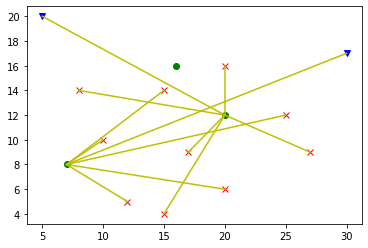


Mejor distribución en la última generación:


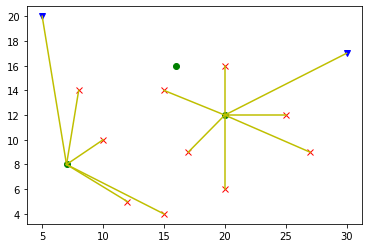


Grafico de evolución del fitness:


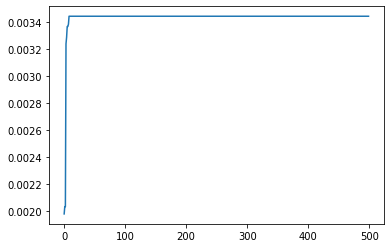

In [6]:
def algoritmo_genetico():
  individuos_por_generacion = 100
  num_individuos_elite = 10
  generaciones = 500
  generacion = [Cromosoma() for i in range(individuos_por_generacion)]
  lista_mejor_cromosoma = []

  print('Iniciando iteraciones...')
  for i in range(generaciones):
    # Clasifico mi ranking actual de mejores individuos
    ranking = list(sorted(generacion, key=lambda crom:crom.fitness, reverse=True))[:num_individuos_elite]
    lista_mejor_cromosoma.append(ranking[0])
    if i%100 == 0:
      print(ranking[0].fitness)

    # Lista de individuos combinados
    combinados = []
    for crom in ranking:
      for num in range(int(individuos_por_generacion*0.2/len(ranking))):
        newcrom = deepcopy(crom)
        newcrom.combinar_cadena(ranking[np.random.randint(len(ranking))])
        combinados.append(newcrom)
    
    # Lista de individuos mutados
    mutados = []
    for crom in ranking:
      for num in range(int(individuos_por_generacion*0.5/len(ranking))):
        newcrom = deepcopy(crom)
        newcrom.mutar_cadena()
        mutados.append(newcrom)
    
    # Lista de regenerados
    regenerados = []
    # Cambiar conexiones generadora
    for crom in ranking:
      for num in range(int(individuos_por_generacion*0.2/len(ranking))):
        newcrom = deepcopy(crom)
        newcrom.conexion_aleatoria_generadoras()
        regenerados.append(newcrom)
    
    # Cambiar conexiones usuario
    for crom in ranking:
      for num in range(int(individuos_por_generacion*0.1/len(ranking))):
        newcrom = deepcopy(crom)
        newcrom.conexion_aleatoria_usuarios()
        regenerados.append(newcrom)
    
    # Definimos la nueva generación
    generacion = ranking + combinados + mutados + regenerados

  print('Algoritmo genético finalizado!')

  # Imprimimos el mejor cromosoma de la ultima generación
  print('\nMejor cromosoma:')
  print(lista_mejor_cromosoma[-1])

  print('\nMejor Fitness: ', end='')
  print(lista_mejor_cromosoma[-1].fitness)

  print('\nMejor Coste: ', end='')
  print(1/lista_mejor_cromosoma[-1].fitness)

  # Graficamos el primer cromosoma de la primera y la última generación
  print('\nMejor distribución en la primera generación:')
  lista_mejor_cromosoma[0].graficar_cromosoma()
  print('\nMejor distribución en la última generación:')
  lista_mejor_cromosoma[-1].graficar_cromosoma()

  # Graficamos el progreso del fitness de las distribuciones
  costes = []
  for crom in lista_mejor_cromosoma:
    costes.append(crom.fitness)
  print('\nGrafico de evolución del fitness:')
  plt.plot(costes)
  plt.show()

algoritmo_genetico()

Para generar otra distribución, generaremos una lista aleatoria de usuarios, subestaciones y generadoras

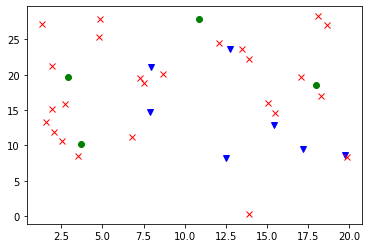

Usuarios:25, Generadoras:7, Subestaciones:4;
Iniciando iteraciones...
0.0011491979750544684
0.0015908583970097537
0.0015908583970097537
0.0015908583970097537
0.0015908583970097537
Algoritmo genético finalizado!

Mejor cromosoma:
[0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1.]

Mejor Fitness: 0.0015908583970097537

Mejor Coste: 628.5914584727611

Mejor distribución en la primera generación:


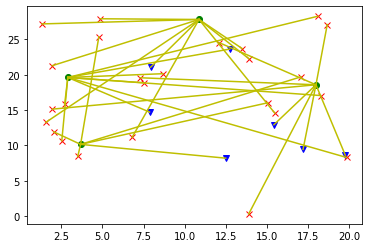


Mejor distribución en la última generación:


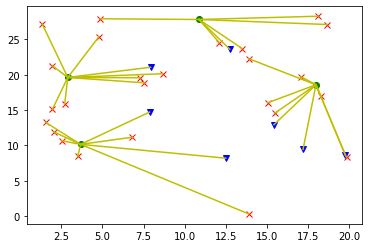


Grafico de evolución del fitness:


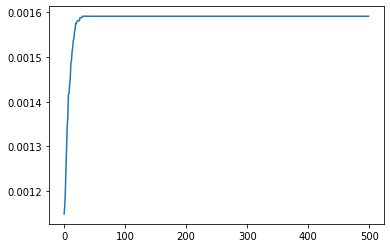

In [11]:
# Generamos nuevas listas
lista_de_generadoras = [Generadora(100, np.random.random()*20, np.random.random()*30) for i in range(7)]
lista_de_subestaciones = [Subestacion(50, np.random.random()*20, np.random.random()*30) for i in range(4)]
lista_de_usuarios = [Usuario(10, np.random.random()*20, np.random.random()*30) for i in range(25)]

# Mostramos la nueva distribución
# Generadoras en Azul
gx = [generadora.x for generadora in lista_de_generadoras]
gy = [generadora.y for generadora in lista_de_generadoras]
plt.plot(gx, gy, 'bv')

# Subestaciones en Verde
sx = [subestacion.x for subestacion in lista_de_subestaciones]
sy = [subestacion.y for subestacion in lista_de_subestaciones]
plt.plot(sx, sy, 'go')

# Usuarios en Rojo
ux = [usuario.x for usuario in lista_de_usuarios]
uy = [usuario.y for usuario in lista_de_usuarios]
plt.plot(ux, uy, 'rx')
plt.show()

# Numeros para definir el cromosoma a crear
N_USUARIOS = len(lista_de_usuarios)
N_GENERADORAS = len(lista_de_generadoras)
N_SUBESTACIONES = len(lista_de_subestaciones)
N_CROMOSOMAS = (N_GENERADORAS + N_USUARIOS) * N_SUBESTACIONES


print('Usuarios:{}, Generadoras:{}, Subestaciones:{};'.format(N_USUARIOS, N_GENERADORAS, N_SUBESTACIONES))

# Corremos el algoritmo Genético
algoritmo_genetico()

# Conclusiones

Este algoritmo es muy poderoso para encontrar caminos óptimos en distribuciones en las cuales es difícil determinar cual ruta utilizar. Podemos observar en el último ejemplo, la forma en la que podemos organizar un mapa en el cual es difícil imaginarse soluciones que consideren tanto la distancia como el coste de la línea. Es en estos casos en donde el algoritmo genético puede ayudarnos a descubrir formas óptimas de solucionar un problema en concreto.